In [2]:
%load_ext autoreload
%autoreload 2

In [11]:
# numeric imports
import torch
import numpy as np
# gp imports
import gpytorch
from src.models.exact.bivariate_structure import Matern12GP
from src.models.sparse.kronecker_structure import Matern12SVGP, Matern12VFFGP, Matern12B1SplineASVGP, Matern12B0SplineGriddedGP
# plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
# util imports
from src.utils.datagenerators import gen_2d
# misc imports
from tqdm import tqdm

# Generate Data

In [3]:
# data generating function
def latent_function_2d(x1, x2):
    return (
        np.sin(5 * x1) + np.cos(7 * x2) +
        0.5 * np.sin(15 * x1) + 0.5 * np.cos(12 * x2) +
        0.2 * np.sin(20 * x1) + 0.2 * np.cos(25 * x2)
    )

In [4]:
# data generating meta
X1LIMS = (0., 1.)
X2LIMS = (0., 1.)
N_OBS = 25 # 25 X 25 = 625 observations
# plotting meta
EXTENT = [X1LIMS[0], X1LIMS[1], X2LIMS[0], X2LIMS[1]]

In [5]:
X, y = gen_2d(latent_function_2d, X1LIMS, X2LIMS, N_OBS)

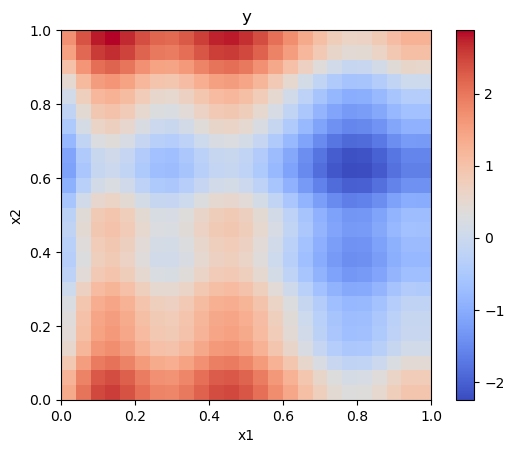

In [6]:
plt.imshow(y.reshape(N_OBS, N_OBS), extent = EXTENT, cmap='coolwarm', origin='upper')
plt.colorbar()
# plot style
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('y');

In [8]:
# training data
X_train = torch.tensor(X).to(torch.float64)
y_train = torch.tensor(y).to(torch.float64)

# GP Models

## Exact GP

In [23]:
# create gp
gp = Matern12GP(X_train, y_train)

In [24]:
# fit the Exact GP
LR = 0.01
NITER = 1000
# set model and likelihood into training mode
gp.train()
gp.likelihood.train()
# define the optimizer
optimizer = torch.optim.Adam(gp.parameters(), lr = LR)
# define the mll
mll = gpytorch.mlls.ExactMarginalLogLikelihood(gp.likelihood, gp)
gp_history = torch.empty(NITER)
for i in tqdm(range(NITER)):
    optimizer.zero_grad()
    output = gp(gp.train_x)
    loss = -mll(output, gp.train_y)
    gp_history[i] = loss.item()
    loss.backward()
    optimizer.step()

print('='*((5*15) + 4))
print(f"{'Iteration':^15}|{'Loss':^15}|{'Noise':^15}|{'Lengthscale':^15}|{'Outputscale':^15}")
print('='*((5*15) + 4))
print(f"{i+1:^15}|{loss.item():^15.3f}|{gp.likelihood.noise.item():^15.3f}|{gp.kernel.base_kernel.lengthscale.item():^15.3f}|{gp.kernel.outputscale.item():^15.3f}")

100%|██████████| 1000/1000 [00:26<00:00, 37.54it/s]

   Iteration   |     Loss      |     Noise     |  Lengthscale  |  Outputscale  
     1000      |    -0.625     |     0.000     |     1.826     |     0.633     


In [28]:
# plt.plot(gp_history)

## SVGP

In [29]:
# inducing points
N_INDUCING = 10
Z = torch.tensor(np.random.rand(N_INDUCING, 2), dtype=torch.float64)

In [30]:
svgp = Matern12SVGP(X_train, y_train, Z).to(torch.float64)

In [32]:
# fit SVGP
LR = 0.01
NITER = 1000
optimizer = torch.optim.Adam(svgp.parameters(), lr=LR)
# perform gradient descent
svgp_history = torch.empty(NITER)
for i in tqdm(range(NITER)):
    optimizer.zero_grad()
    elbow = -svgp._elbo()
    svgp_history[i] = elbow.item()
    elbow.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/maxnorman/opt/anaconda3/envs/project_env/lib/python3.9/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")
100%|██████████| 1000/1000 [01:27<00:00, 11.46it/s]


In [34]:
# plt.plot(svgp_history)

## VFFGP

In [38]:
# frequencies
N_FREQ = 15
VFFDIM1LIMS = (-1, 2)
VFFDIM2LIMS = (-1, 2)

In [42]:
vffgp = Matern12VFFGP(X_train, y_train, N_FREQ, VFFDIM1LIMS, VFFDIM2LIMS).to(torch.float64)

In [47]:
# fit SVGP
LR = 0.01
NITER = 1000
optimizer = torch.optim.Adam(vffgp.parameters(), lr=LR)
# perform gradient descent
vffgp_history = torch.empty(NITER)
for i in tqdm(range(NITER)):
    optimizer.zero_grad()
    elbow = -svgp._elbo()
    vffgp_history[i] = elbow.item()
    elbow.backward()
    optimizer.step()

100%|██████████| 1000/1000 [01:14<00:00, 13.40it/s]


In [49]:
#plt.plot(vffgp_history)

## ASVGP

In [79]:
# knots
N_KNOTS = 15
ASVGPDIM1LIMS = (-1, 2)
ASVGPDIM2LIMS = (-1, 2)

In [80]:
asvgp = Matern12B1SplineASVGP(X_train, y_train, N_KNOTS, ASVGPDIM1LIMS, ASVGPDIM2LIMS).to(torch.float64)

In [81]:
# fit SVGP
LR = 0.01
NITER = 1000
optimizer = torch.optim.Adam(asvgp.parameters(), lr=LR)
# perform gradient descent
asvgp_history = torch.empty(NITER)
for i in tqdm(range(NITER)):
    optimizer.zero_grad()
    elbow = -asvgp._elbo()
    asvgp_history[i] = elbow.item()
    elbow.backward()
    optimizer.step()

100%|██████████| 1000/1000 [01:20<00:00, 12.42it/s]


In [84]:
# plt.plot(asvgp_history)

## Gridded GP

In [86]:
N_KNOTS = 15
GRIDDEDDIM1LIMS = (0, 1)
GRIDDEDDIM2LIMS = (0, 1)

In [95]:
griddedgp = Matern12B0SplineGriddedGP(X_train, y_train, N_KNOTS, GRIDDEDDIM1LIMS, GRIDDEDDIM2LIMS).to(torch.float64)

In [96]:
# fit SVGP
LR = 0.01
NITER = 1000
optimizer = torch.optim.Adam(griddedgp.parameters(), lr=LR)
# perform gradient descent
griddedgp_history = torch.empty(NITER)
for i in tqdm(range(NITER)):
    optimizer.zero_grad()
    elbow = -griddedgp._elbo()
    griddedgp_history[i] = elbow.item()
    elbow.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/maxnorman/opt/anaconda3/envs/project_env/lib/python3.9/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")
100%|██████████| 1000/1000 [01:28<00:00, 11.28it/s]


# Model Comparison

In [108]:
# make some test data
N_STAR = 50
x1_star = np.linspace(0, 1, N_STAR)
x2_star = np.linspace(0, 1, N_STAR)
X1_star, X2_star = np.meshgrid(x1_star, x2_star)
X_star = np.vstack([X1_star.ravel(), X2_star.ravel()]).T

In [109]:
X_test = torch.tensor(X_star).to(torch.float64)

In [110]:
# get posteriod
gp_pred = gp.posterior(X_test)
svgp_pred = svgp.posterior(X_test)
vffgp_pred = vffgp.posterior(X_test)
asvgp_pred = asvgp.posterior(X_test)
griddedgp_pred = griddedgp.q_v()

/Users/maxnorman/opt/anaconda3/envs/project_env/lib/python3.9/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")


Text(0.5, 1.0, 'ASVFFGP')

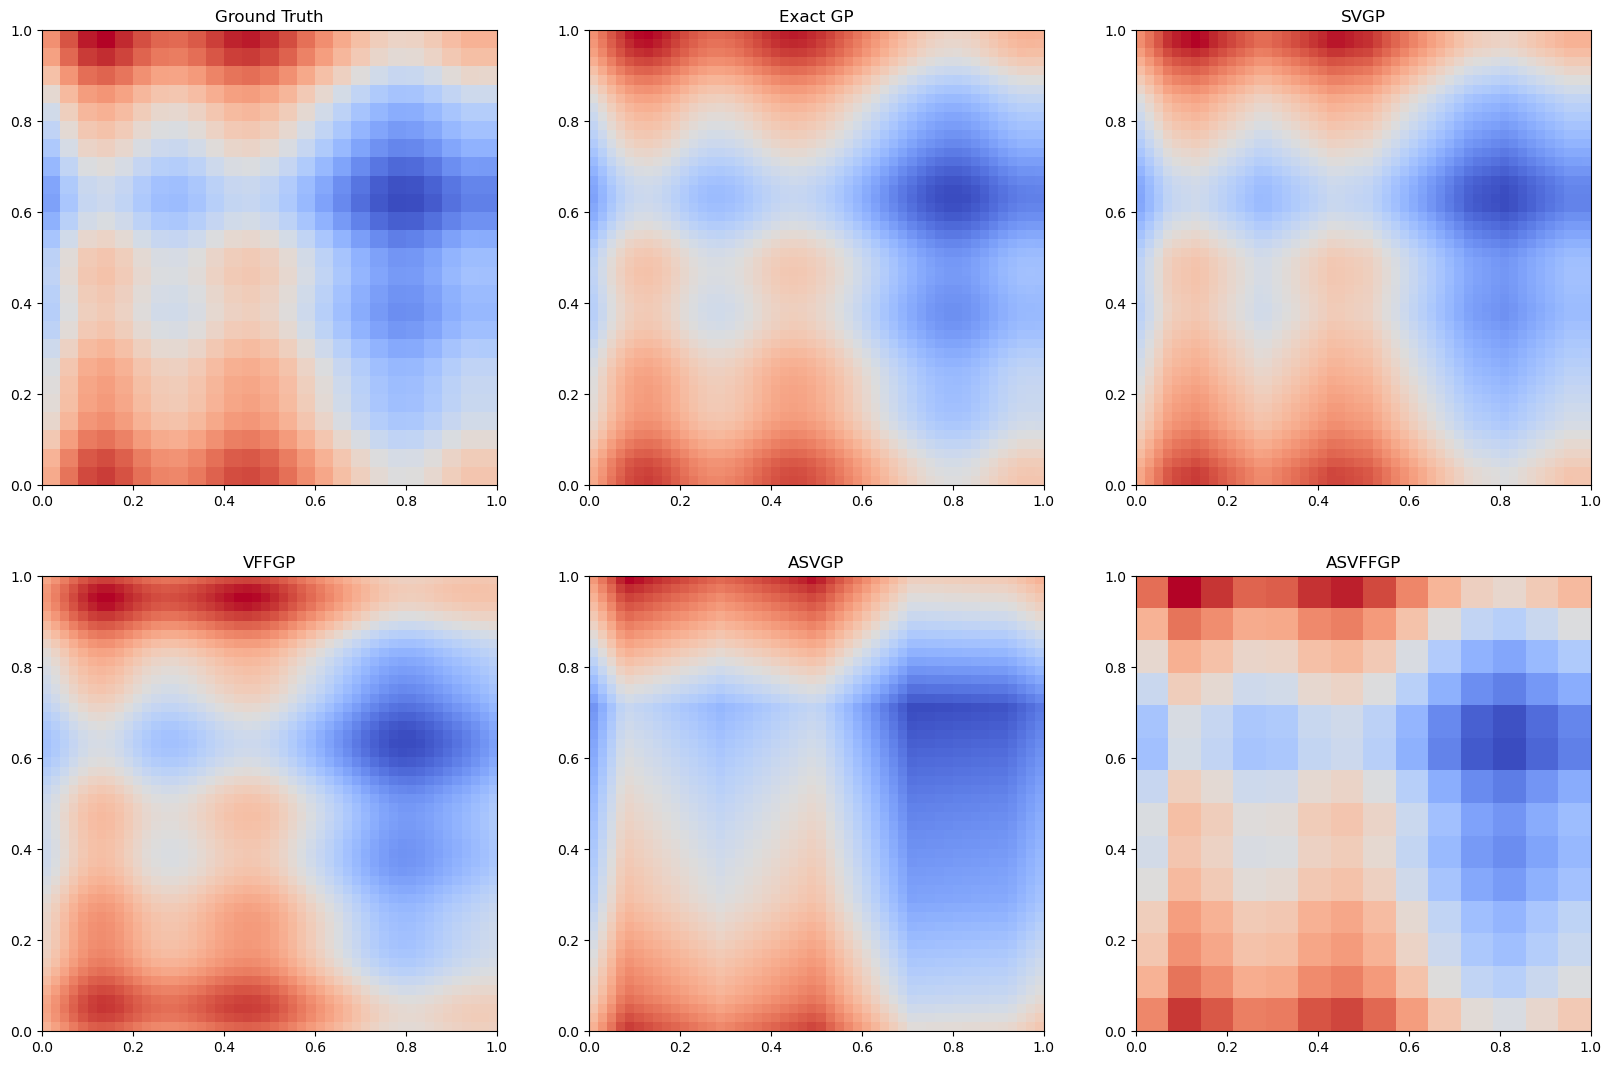

In [123]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 13))

# ground truth
ax1.imshow(y.reshape(N_OBS, N_OBS), cmap = 'coolwarm', origin = 'upper', extent = EXTENT)
ax1.set_title('Ground Truth')

# exact gp
ax2.imshow(gp_pred.mean.reshape(N_STAR, N_STAR), cmap = 'coolwarm', origin = 'upper', extent = EXTENT)
ax2.set_title('Exact GP')

# svgp
ax3.imshow(svgp_pred.mean.reshape(N_STAR, N_STAR).detach().numpy(), cmap = 'coolwarm', origin = 'upper', extent = EXTENT)
ax3.set_title('SVGP')

# vffgp
ax4.imshow(vffgp_pred.mean.reshape(N_STAR, N_STAR).detach().numpy(), cmap = 'coolwarm', origin = 'upper', extent = EXTENT)
ax4.set_title('VFFGP')

# asvgp
ax5.imshow(asvgp_pred.mean.reshape(N_STAR, N_STAR).detach().numpy(), cmap = 'coolwarm', origin = 'upper', extent = EXTENT)
ax5.set_title('ASVGP')

# griddedgp_pred
ax6.imshow(griddedgp_pred.mean.reshape(N_KNOTS-1, N_KNOTS-1).detach().numpy().T, cmap = 'coolwarm', origin = 'upper', extent = EXTENT)
ax6.set_title('ASVFFGP')
